# sortsol

In [63]:
import syrkis

import jax
import jax.numpy as jnp
from jax import grad, jit, vmap, random
from evosax import PSO

from functools import partial
import seaborn as
from typing import Callable, Tuple, List, Dict, Any, Optional

In [64]:
rng = random.PRNGKey(0)
N_DRONES = 256
kernel = jnp.ones((3, 3))[:, :, None, None]

In [65]:
# TYPES
Array       = jnp.ndarray
Swarm       = Tuple[Array, Array] # (position, velocity)
Population  = Tuple[Swarm]


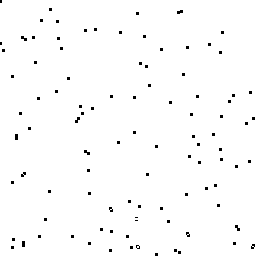
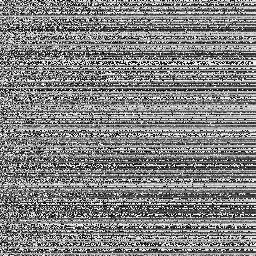
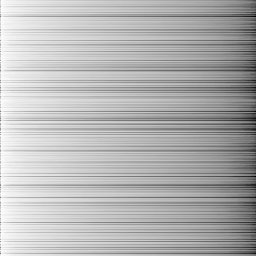

In [82]:
def grid_positions(n_drones) -> Array:
    # n_drones is power of 2
    lo, hi = - int(n_drones ** 0.5), int(n_drones ** 0.5)
    span = jnp.linspace(lo, hi, int(n_drones ** 0.5))
    x, y = jnp.meshgrid(span, span)
    coords = jnp.stack([x.ravel(), y.ravel()], axis=1)
    return coords

def init_swarm(rng: Array, n_drones: int) -> Swarm:
    coords = grid_positions(n_drones)
    velocity = random.normal(rng, (n_drones, 2))
    return coords, velocity

def conv2d(x, w):
    return jax.lax.conv_general_dilated(x, w, window_strides=(1, 1),padding='SAME',dimension_numbers=("NHWC", "HWIO", "NHWC")).squeeze()

def quantize(swarm: Swarm, resolution: int = 256) -> Array:
    image = jnp.zeros((resolution, resolution))
    coords = (swarm[0] * 1).astype(int) + resolution // 2
    image = image.at[(coords[:, 0].astype(int), coords[:, 1].astype(int))].set(1)[None, :, :, None]
    return (conv2d(image, kernel) == 1).astype(int)

def positions(swarm: Swarm) -> Array:  # TODO: sort by distance (probably)
    delta = swarm[0][:, jnp.newaxis] - swarm[0][jnp.newaxis, :]                      
    other_dists = jnp.sqrt(jnp.sum(delta ** 2, axis=-1))                          # others
    other_theta = jnp.arctan2(delta[..., 1], delta[..., 0])
    idx = jnp.argsort(other_dists, axis=-1)[:, 1:]                                # sort others and remove self
    other_dists = other_dists[jnp.arange(other_dists.shape[0])[:, None], idx]     # origin
    other_theta = other_theta[jnp.arange(other_theta.shape[0])[:, None], idx]
    origin_dist = jnp.sqrt(jnp.sum(swarm[0] ** 2, axis=-1))
    origin_theta = jnp.arctan2(swarm[0][..., 1], swarm[0][..., 0])
    return origin_theta, origin_dist, other_dists, other_theta

def act(rng, swarm: Swarm, momentum=0.6) -> Swarm:
    coords, velocity = swarm
    obs = observe(swarm)
    action = model(rng, obs)  # n_drones x 2 (theta, speed)
    dx = action[:, 1] * jnp.cos(action[:, 0])
    dy = action[:, 1] * jnp.sin(action[:, 0])
    new_coords = coords + velocity
    new_velocity = momentum * velocity + (1 - momentum) * jnp.stack([dx, dy], axis=1)
    new_velocity = jax.nn.tanh(new_velocity) * 2
    return new_coords, new_velocity

def model(rng, params, obs) -> Array:
    # given an observation, predict the next action
    noise = random.normal(rng, (obs.shape[0], 2)) * 0.1
    action = jnp.tanh(jnp.dot(obs, params) + noise)
    return action # theta and speed

def fitness(image) -> Array:
    clash_term = 1 - jnp.sum(image) / (N_DRONES * 9)   # minimise to avoid collisions and going out of bounds
    return clash_term

def observe(swarm: Swarm) -> Array:
    origin_theta, origin_dist, other_dists, other_theta = positions(swarm)
    thetas = jnp.concatenate([origin_theta[:, None], other_theta], axis=1)  # n_drones x 1 + n_drones
    dists  = jnp.concatenate([origin_dist[:, None], other_dists], axis=1)   # n_drones x 1 + n_drones
    obs    = jnp.concatenate([thetas, dists], axis=1)                       # n_drones x 2 + 2 * n_drones
    return obs

def resize(source, target):
    # make source have same dimensions as target (for plotting)
    return jax.image.resize(source, (target.shape[0], target.shape[1]), method='nearest')


strategy = PSO(popsize=100, pholder_params=jnp.zeros(N_DRONES * 2))   # for each drone, theta and speed

rng, key = random.split(random.PRNGKey(0))
swarm = init_swarm(key, N_DRONES)
for _ in range(1000):
    rng, key = random.split(rng)
    obs = observe(swarm)
    theta, dists = obs[:, :N_DRONES], obs[:, N_DRONES:]
    dists /= dists.max()
    # standardise theta to be between 0 and 1 
    theta /= jnp.pi
    theta = (theta - theta.min()) / (theta.max() - theta.min())
    swarm = act(key, swarm)
    image = quantize(swarm)
    low_bar = [f"fitness: {fitness(image):.2f}", f"n_drones: {N_DRONES}", f"momentum: {0.6}"]
    imgs = jnp.stack([resize(image, dists)[:, :, None], theta[:, :, None], dists[:, :, None]], axis=0)
    syrkis.plot.multiples(imgs, n_cols=3, n_rows=1, low_bar=low_bar, invertable=True)

In [67]:
theta

Array([[0.91401327, 0.32082382, 0.67669827, ..., 0.8972453 , 0.9017563 ,
        0.89348596],
       [0.16384797, 0.8695278 , 0.15256459, ..., 0.14145315, 0.12254583,
        0.14134571],
       [0.10055713, 0.1204863 , 0.27272603, ..., 0.11324704, 0.09621523,
        0.11469419],
       ...,
       [0.33910272, 0.39448577, 0.6019737 , ..., 0.400305  , 0.35701734,
        0.3412198 ],
       [0.1718192 , 0.24786834, 0.8419523 , ..., 0.33506998, 0.13276929,
        0.3191351 ],
       [0.83071417, 0.8019162 , 0.90371823, ..., 0.7248683 , 0.8801105 ,
        0.8709976 ]], dtype=float32)

In [68]:
def get_neighbours(drones: Swarm, dists: Array, n_neighbours: int = 8) -> Array:
    idxs = jnp.argsort(dists, axis=-1)[:, 1:n_neighbours+1]
    dists = jnp.take_along_axis(dists, idxs, axis=-1)
    neigh = drones[0][idxs] - drones[0][:, jnp.newaxis, :]
    phi = jnp.arctan2(neigh[..., 1], neigh[..., 0])
    theta = jnp.arctan2(neigh[..., 2], neigh[..., 0])
    neigh = jnp.stack([dists, phi, theta], axis=-1)
    return neigh

In [69]:
def init_resevoir(observation_space: int, latent_space: int):
    return jax.random.uniform(rng, (observation_space, latent_space))

In [70]:
def collision_test(drones: Swarm, dists, threshold: float = 1.0) -> Array:
    mask = jnp.triu(dists < threshold, k=1)
    mask = jnp.any(mask, axis=0) | jnp.any(mask, axis=1)
    return ~mask

def step_fn(drones: Swarm, rng: Array) -> Swarm:
    position, velocity, mask, battery = drones
    dists = drone_dists(drones)
    action = action_fn(observe(position), mask, rng)
    velocity = velocity * mask[:, jnp.newaxis]
    position = position + (velocity * action)
    velocity = velocity + action
    battery = battery - jnp.sqrt(jnp.sum(action ** 2, axis=-1))
    return position, velocity, battery

In [71]:
def generation(drones: Swarm, rng: Array, n_steps=100) -> Swarm:
    position, velocity, mask, battery = drones
    for step in range(n_steps):
        rng, key = jax.random.split(rng)
        mask &= collision_test(position, velocity, mask)
        position, velocity, battery = step_fn(position, velocity, mask, battery, key)
        img = quantize(position)

def evolve(rng: Array, n_generations: int = 100, n_swarms=32, population_size=128) -> Swarm:
    # strategy = CMA_ES(popsize=20, num_dims=2, elite_ratio=0.5)
    population = [init_drones() for _ in range(population_size)]
    strategy = SimpleGA(population, fitness_fn)
    for gen in tqdm(range(n_generations)):
        population = vmap(generation, in_axes=(0, None))(population, rng)
        population = strategy.ask()
    return population

def fitness_fn(params):
    params = jnp.array(params).reshape((8, 3))
    drones = init_drones(position_fn=partial(grid_positions, dispersion=100))
    fitness = generation(params, drones)
    fitness = reward_fn(fitness)
    return fitness

drones = init_drones()

NameError: name 'init_drones' is not defined